# Abstract

Software systems have become more flexible and feature-rich. For example, the configuration file for MySQL has more than 200 configuration entries with different subentries. As a result, configuring these systems is a complicated task and frequently causes configuration errors. Currently, in most cases, misconfigurations are detected by manually specified rules. However, this process is tedious and not scalable. In this project, we propose data-driven methods to detect misconfigurations by discovering frequently occurring patterns in configuration files.


# Introduction
Configuration errors are one of the major underlying causes of modern software system failures. In 2017, AT&T’s 911 service went down for 5 hours because of a system configuration change. About 12600 unique callers were not able to reach 911 during that period. In another similar incident, Facebook and Instagram went down because of a change that affected facebook’s configuration systems. These critical system failures are ubiquitous - In one empirical study, researchers found that the percentage of system failure caused by configuration errors is higher than the percentage of failure resulting from bugs, 30% and 20% respectively.

Some of the configuration files are written by experts and customized by users such as tuned files, while others are completely configured by end-users. When writing configuration files, users usually take existing files and modify them with little knowledge of the system. The non-expert user can then easily introduce errors. Even worse, the original file may already be corrupted, and the errors are propagated further. In this notebook, we explored misconfiguration detection in MySQL configuration files using data-driven methods.

In this notebook, we will cover the following topics:

## Contents
- Parsing configuration files
- Misconfiguration detection framework
    - Spelling error detection 
    - Data type error detection
- Conclusion

In [1]:
import os
import json
import pandas as pd
import numpy as np
from itertools import combinations
import nltk
import re
from collections import defaultdict
import configparser
from utils import create_keyvalue_df
from IPython.display import Image
from utils import spell_error
from utils import mis_spell_detection
from utils import create_intermediate, create_type_rule
from utils import mis_type_detection

#  Parsing configuration files

Configuration files are used to assigning values to system variables, and there is no explicit structure policy for these entries in configuration files. The configuration files format can be INI, YAML, JSON, XML, etc. Otherwise, developers can define new formats depending on program requirements. Red Hat Insights provides [parsers](https://insights-core.readthedocs.io/en/latest/parsers_index.html) for configuration files utilized by different Red Hat-based systems. 

This notebook demonstrates our analysis on INI based configuration file, but it's valid for any key-values-based configuration files. The INI file consists of sections, each led by a [section] header. Each section is followed by key/value entries separated by = or : character. It may include comments, prefixed by # or ; symbol. 

Galera is a multi-master replication cluster for MySQL databases,  which is configured using the galera.cnf configuration file. galera.cnf is INI type configuration file. In this notebook, we are using galera.cnf for analysis, but this analysis can easily be extended to any key-values-based configuration file.  

In [2]:
with open('../data/raw/mysql/015c69fcac9642fd6ccedb035445eda2.cnf', 'r') as f:
    #print(f.read())
    #Remove the above comment to take a look at the configuration file.
    pass

We developed Create_KeyValue_df function, which takes input as a folder path of s3 bucket and creates a list of dictionaries as output. This function works for all INI based configuration files.


In [9]:
data_dir = '../data/raw/mysql'
dict_list = create_keyvalue_df(data_dir,fixed_typos=False)
config_df = pd.DataFrame(dict_list)
config_df = config_df.dropna(axis=1, how='all')

# Misconfiguration detection
The misconfiguration detection framework adopted in this project is inspired by the research paper ['Synthesizing Configuration File Specifications with Association Rule Learning'](https://www.cs.yale.edu/homes/zhai-ennan/configv-oopsla17.pdf#cite.santolucitoCAV). Association rule learning is a method to discover frequently occurring patterns or associations between variables in a dataset. In association rule learning, support and confidence are two metrics widely used to filter the proposed rules. Support is the percentage of times that the keywords in the proposed rule have been seen in the training configuration files. Confidence is the percentage of times the proposed rule has held true over the training configuration files.

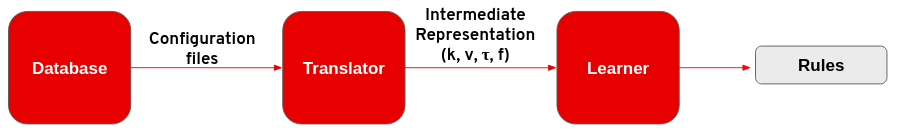

In [10]:
Image('images/framework.png')

As you can see in the above image, misconfiguration detection framework has two important modules: translator and learner. <br>
- **Translator**: Translator works as a parser, translator converts raw configuration files into an intermediate representation which generally has a format of key, value, data type, frequency (k, v, τ, f) <br>
- **Learner**:: Learner discovers frequently occurring patterns or associations between keywords in configuration files to derive rules. <br>

## Spelling error detection framework
Following is the example of a spelling error detection framework. [detailed notebook](https://github.com/aicoe-aiops/configuration-files-analysis/blob/master/notebooks/Misconfiguration_detection_framework_for_spelling_errors.ipynb)

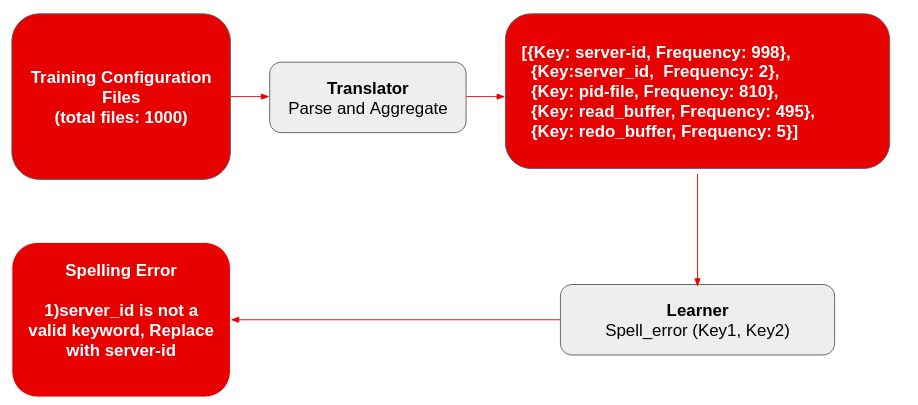

In [11]:
Image('images/spell_error_framework.png')

Steps for spelling error detection <br>
1) Translator finds the frequency of each keyword across the training set. <br>
2) Learner proposes errors by mapping lower frequency keywords to a similar higher frequency keyword. We calculated the similarity between keywords using Levenshtein distance. Finally, learner filters the proposed errors using support and confidence. <br>


In [ ]:
# translator
key_dict = config_df.count().to_dict()
# learner
spell_errors = spell_error(key_dict, len(dict_list), support_t = 0.01)
spell_errors

Inferences of some of the above-detected errors  <br>
- keyword 'bind_address' is misspelled. It should be replaced by 'bind-address' <br>
- keyword 'binlog_do_db' is misspelled. It should be replaced by 'binlog-do-db' <br>
and so on.

In the following cell, we found spelling errors in a mysql.cnf file in our dataset. <br>
We parsed the configuration file and checked if there are lower-frequency keywords similar to a higher-frequency keyword. If such keywords exist, we throw misspell errors. <br>

One of the most misconfigured MySQL performance features is MySQL 'query_cache_size' [refrence](https://haydenjames.io/mysql-query-cache-size-performance/). 'query_cache_size' system variable is used for query caching, and it can significantly improve the performance of the MySQL systems. A user assigned 20M memory to 'query_cache_size' to improve the performance but misspelled key as 'query-cache-size' resulting in a default 1M memory assignment causing poor performance.

In [10]:
freq_query_cache_size1 =  key_dict['query-cache-size'] if 'query-cache-size' in key_dict else 0
freq_query_cache_size2 = key_dict['query_cache_size'] if 'query_cache_size' in key_dict else 0
print('Frequency of \'query-cache-size\' is', freq_query_cache_size1)
print('Frequency of \'query_cache_size\' is', freq_query_cache_size2)
print('As we can see above, we have \'query_cache_size\' as a key in', freq_query_cache_size2, 'files. But we have \'query-cache-size\' as a key for only', freq_query_cache_size1, 'files. Hence, \'query-cache-size\' must be misspelled.')

Frequency of 'query-cache-size' is 9
Frequency of 'query_cache_size' is 169
As we can see above, we have 'query_cache_size' as a key in 169 files. But we have 'query-cache-size' as a key for only 9 files. Hence, 'query-cache-size' must be misspelled.


In [11]:
mis_spell_detection(key_dict, '../data/raw/mysql/015c69fcac9642fd6ccedb035445eda2.cnf')

Spell_Error: Key 'query-cache-size' should be replaced by 'query_cache_size'


## Data type error detection framework
Following is the example of a data type error detection framework. [detailed notebook](https://github.com/aicoe-aiops/insights-configuration-files-analysis/blob/master/notebooks/Misconfiguration_detection_framework_for_data_type_errors.ipynb)

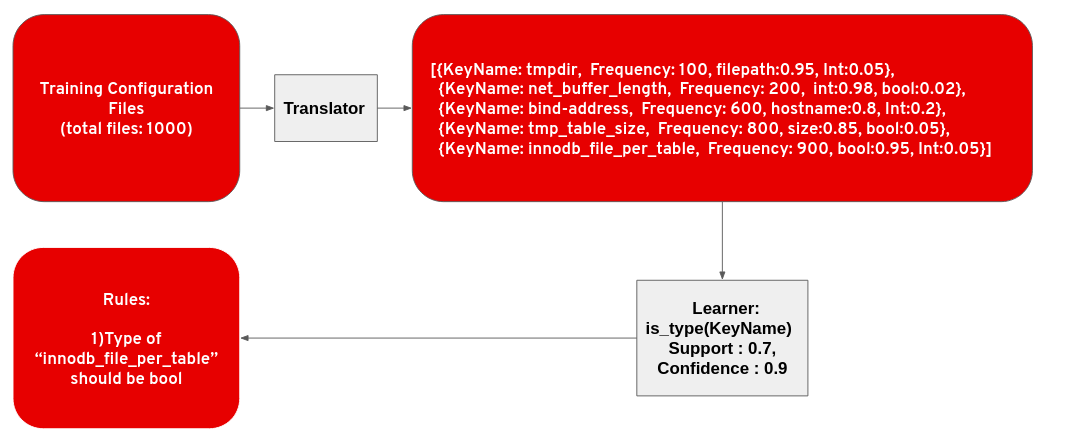

In [12]:
Image('images/type_error_framework.png')

Steps for data type error detection <br>
1) Translator parses the configuration files, determines the data type of values, and aggregate results for each key. <br>
2) Learner proposes rules by assigning every possible datatype to each keyword in configuration files. .Then filter proposed rules using support and confidence. <br>

In [13]:
# translator
intermediate_representation = create_intermediate(config_df)
total_files = len(dict_list)

# learner
datatype_dict = create_type_rule(intermediate_representation, total_files, confidence_t = 0.9, support_t = 0.1)
datatype_dict

[{'key_name': 'socket', 'datatype': ['filename||filepath+filename']},
 {'key_name': 'port', 'datatype': ['int', 'size', '0||1']},
 {'key_name': 'user', 'datatype': ['string']},
 {'key_name': 'max_allowed_packet', 'datatype': ['int', 'size']},
 {'key_name': 'expire_logs_days', 'datatype': ['int', 'size', '0||1']},
 {'key_name': 'log-error', 'datatype': ['filename||filepath+filename']},
 {'key_name': 'long_query_time', 'datatype': ['int', 'size', '0||1']},
 {'key_name': 'key_buffer_size', 'datatype': ['int', 'size']},
 {'key_name': 'table_cache', 'datatype': ['int', 'size', '0||1']},
 {'key_name': 'thread_concurrency', 'datatype': ['int', 'size', '0||1']},
 {'key_name': 'thread_cache_size', 'datatype': ['int', 'size', '0||1']},
 {'key_name': 'open_files_limit', 'datatype': ['int', 'size', '0||1']},
 {'key_name': 'max_connections', 'datatype': ['int', 'size', '0||1']},
 {'key_name': 'read_buffer_size', 'datatype': ['int', 'size']},
 {'key_name': 'read_rnd_buffer_size', 'datatype': ['int',

Following are some of the generated rules for mysql.conf file <br>
- {'key_name': 'character-set-server', 'datatype': ['string']}. This rule states that key  'character-set-server' should have data type as 'string'. <br>
- {'key_name': 'default-character-set', 'datatype': ['string']}. This rule states that key 'default-character-set' should have data type as 'string'. <br>
and so on

In the following example, we found data type errors in a mysql.conf file selected from our dataset. <br>
keyword 'socket' takes the input value as file_directory + file_name, i.e., location for socket file that the server uses for communication with local clients  ([Reference](https://dev.mysql.com/doc/refman/8.0/en/problems-with-mysql-sock.html)). Hence, data type for the keyword should be  'filename||filepath+filename' such as '/var/lib/mysql/mysql.sock'. But in our sample file, the value of keyword 'logfile' is 'MySQL' which has data type as string.

socket file is a pseudo-file used for data transmission by reading and writing.

In [14]:
with open('../data/raw/mysql/11b9fa75593f39219532d16270c0d5d5.cnf') as f:
    config_string = '[dummy_section]\n' + f.read()
config = configparser.ConfigParser(allow_no_value=True, strict=False, inline_comment_prefixes= '#')
cfgs = {}
config.read_string(config_string)
for sect in config.sections():
    cfgs.update(dict(config.items(sect)))
cfgs['socket']

'MySQL'

In [15]:
config_df['socket'].value_counts()

/var/lib/mysql/mysql.sock                    82
/var/run/mysqld/mysqld.sock                  72
/tmp/mysql.sock                              20
/var/run/mysql/mysql.sock                     3
/var/lib/mysql/mysql.sock user=mysql          1
/export/data1/apps/local/mysql/mysql.sock     1
/mysql/mysqld.sock                            1
/db/log/manager.sock                          1
/var/lib/mysql/data/mysql.sock                1
/tmp/mysql_live.sock                          1
${path}/tmp/mysql.sock                        1
/opt/local/lib/mysql5/bin/mysql               1
"TCP/IP"                                      1
/usr/local/mysql/tmp/mysql.sock               1
/tmp/mysql.galera1.sock                       1
/var/www/data/mysql.sock                      1
/app/mysql/var/mysql.sock                     1
/opt/bitnami/mysql/tmp/mysql.sock             1
C:\WebSerer\MySQL\data\mysql.sock             1
"/var/lib/mysql/mysql.sock"                   1
/mysqls/tmp/mysql.sock.gleb.i           

As we can see, keyword 'wsrep_on' has value as ON and 1, which are binary data types.

In [18]:
mis_type_detection(datatype_dict, '../data/raw/mysql/11b9fa75593f39219532d16270c0d5d5.cnf')

Type_Error: Data type of key 'socket' should be ['filename||filepath+filename'] but its given as 'string'


# Conclusion

 - In this notebook, we showed how to parse configuration files using parsers and created a common function to parse INI based configuration files.
 - We demonstrated a misconfiguration detection framework on galera.conf files. 
     - We detected data type errors by matching the target key data type with the data type information inferred from the training set. 
     - We detected spelling error by mapping lower frequency keyword to a similar higher frequency keyword. 
     - We can easily extend this to include other types of errors based on patterns in the configuration files. 
     
In this notebook, we performed our analysis on the mysql.cnf file, However, we can reproduce our analysis for all key-value based configuration files.
